In [26]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from manify.manifolds import ProductManifold
from manify.curvature_estimation.delta_hyperbolicity import delta_hyperbolicity
from manify.curvature_estimation.sectional_curvature import sectional_curvature
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Curvature -3 done
Curvature -2 done
Curvature -1 done
Curvature 0 done
Curvature 1 done
Curvature 2 done
Curvature 3 done


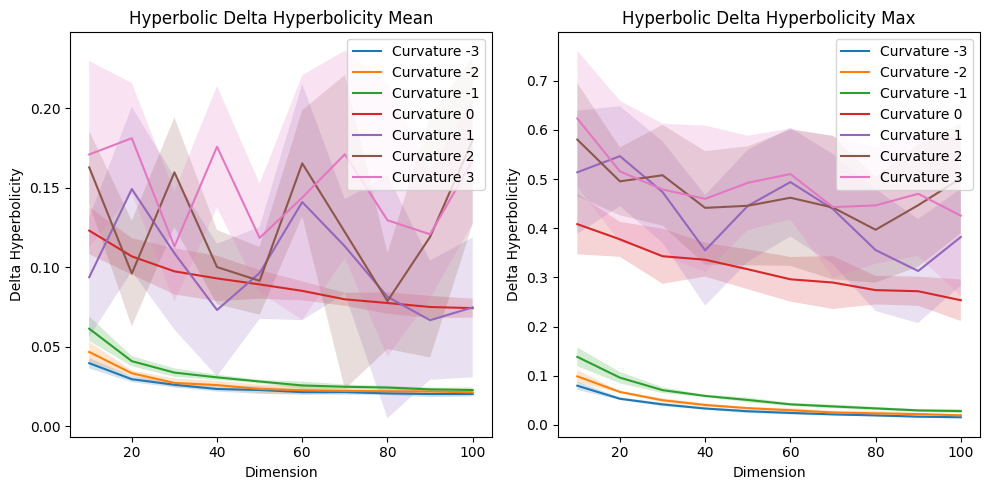

In [28]:
# Curvatures and Dimension in hyperbolic distance metrics
N = 100  # Number of points per sample
n_samples = 10  # Number of samples for confidence intervals

dims = np.linspace(10, 100, 10, dtype=int).tolist()
curvatures = [-3, -2, -1, 0, 1, 2, 3]

# Initialize arrays to store all samples
delta_means_samples = [[] for _ in curvatures]
delta_maxes_samples = [[] for _ in curvatures]

for i, k in enumerate(curvatures):
    for dim in dims:
        # Store results for multiple samples
        sample_means = []
        sample_maxes = []

        for _ in range(n_samples):
            pm = ProductManifold(signature=[(k, dim)])
            X, _ = pm.sample(z_mean=torch.stack([pm.mu0] * N))
            dists = pm.pdist(X)
            delta = delta_hyperbolicity(dists, method="full")
            sample_means.append(torch.abs(delta).mean().item())
            sample_maxes.append(delta.max().item())

        # Calculate mean and std for confidence intervals
        delta_means_samples[i].append((np.mean(sample_means), np.std(sample_means)))
        delta_maxes_samples[i].append((np.mean(sample_maxes), np.std(sample_maxes)))
    print(f"Curvature {k} done")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, k in enumerate(curvatures):
    # Extract means and stds
    means = [m[0] for m in delta_means_samples[i]]
    mean_stds = [m[1] for m in delta_means_samples[i]]
    maxes = [m[0] for m in delta_maxes_samples[i]]
    max_stds = [m[1] for m in delta_maxes_samples[i]]

    # Plot means with confidence intervals
    axs[0].plot(dims, means, label=f"Curvature {k}")
    axs[0].fill_between(
        dims,
        [m - 1.96 * s for m, s in zip(means, mean_stds)],
        [m + 1.96 * s for m, s in zip(means, mean_stds)],
        alpha=0.2,
    )

    # Plot maxes with confidence intervals
    axs[1].plot(dims, maxes, label=f"Curvature {k}")
    axs[1].fill_between(
        dims,
        [m - 1.96 * s for m, s in zip(maxes, max_stds)],
        [m + 1.96 * s for m, s in zip(maxes, max_stds)],
        alpha=0.2,
    )

axs[0].legend()
axs[0].set_xlabel("Dimension")
axs[0].set_ylabel("Delta Hyperbolicity")
axs[0].set_title("Hyperbolic Delta Hyperbolicity Mean")
axs[1].legend()
axs[1].set_xlabel("Dimension")
axs[1].set_ylabel("Delta Hyperbolicity")
axs[1].set_title("Hyperbolic Delta Hyperbolicity Max")

plt.tight_layout()
plt.show()

In [29]:
# Test sectional curvature on real-world network data
from manify.utils.dataloaders import load_hf
import scipy.sparse as sp

# Load polblogs dataset - political blogs network
features, dists, adj_matrix, labels = load_hf("polblogs")
print(f"Polblogs network: {adj_matrix.shape[0]} nodes, {torch.sum(adj_matrix).item()//2} edges")

# Convert to numpy if needed
if hasattr(adj_matrix, 'numpy'):
    adj_dense = adj_matrix.numpy()
else:
    adj_dense = adj_matrix

if hasattr(dists, 'numpy'):
    dists_dense = dists.numpy()
else:
    dists_dense = dists

# Compute sectional curvature using sampled method (faster for larger graphs)
print("Computing sectional curvature (sampled method)...")
curvature_samples = sectional_curvature(
    adjacency_matrix=torch.tensor(adj_dense, dtype=torch.float32),
    distance_matrix=torch.tensor(dists_dense, dtype=torch.float32), 
    method="sampled", 
    n_samples=1000
)
curvature_mean = curvature_samples.mean().item()
print(f"Sectional curvature estimate (mean): {curvature_mean:.4f}")
print(f"Sectional curvature std: {curvature_samples.std().item():.4f}")

# Sanity check: compare with delta hyperbolicity
print("Computing delta hyperbolicity for comparison...")
delta = delta_hyperbolicity(distance_matrix=torch.tensor(dists_dense, dtype=torch.float32), method="global")
print(f"Delta hyperbolicity estimate: {delta:.4f}")

Polblogs network: 1222 nodes, 16775.0 edges
Computing sectional curvature (sampled method)...
Sectional curvature estimate (mean): 0.0276
Sectional curvature std: 0.1029
Computing delta hyperbolicity for comparison...
Delta hyperbolicity estimate: 0.5000


=== Sectional Curvature Analysis ===
Dataset: Polblogs network (1222 nodes, 16775.0 edges)
Method: sampled (n_samples=1000)
Number of curvature samples: 1000
Mean sectional curvature: 0.027640
Standard deviation: 0.102901
Minimum curvature: -0.578125
Maximum curvature: 0.278125
Median curvature: 0.046875

Quantiles:
   5%: -0.140625
  25%: -0.007812
  75%: 0.098958
  95%: 0.164062

For comparison - Delta hyperbolicity: 0.500000


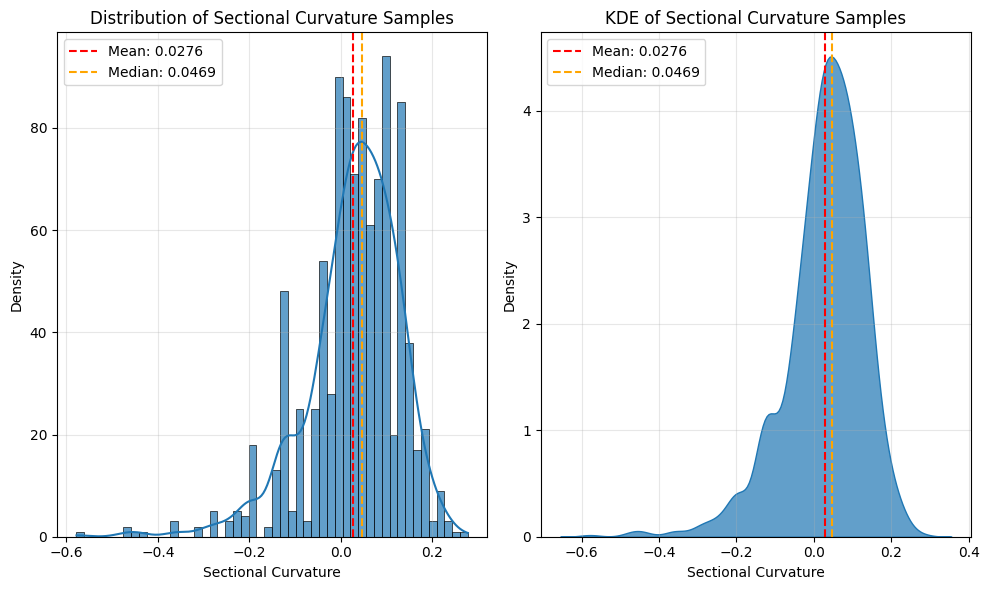

In [30]:
# Print all sectional curvature information
print("=== Sectional Curvature Analysis ===")
print(f"Dataset: Polblogs network ({adj_dense.shape[0]} nodes, {torch.sum(torch.tensor(adj_dense)).item()//2} edges)")
print(f"Method: sampled (n_samples=1000)")
print(f"Number of curvature samples: {len(curvature_samples)}")
print(f"Mean sectional curvature: {curvature_samples.mean().item():.6f}")
print(f"Standard deviation: {curvature_samples.std().item():.6f}")
print(f"Minimum curvature: {curvature_samples.min().item():.6f}")
print(f"Maximum curvature: {curvature_samples.max().item():.6f}")
print(f"Median curvature: {curvature_samples.median().item():.6f}")

# Print quantiles
quantiles = [0.05, 0.25, 0.75, 0.95]
print("\nQuantiles:")
for q in quantiles:
    val = torch.quantile(curvature_samples, q).item()
    print(f"  {q*100:2.0f}%: {val:.6f}")

print(f"\nFor comparison - Delta hyperbolicity: {delta:.6f}")

# Create KDE plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(curvature_samples.numpy(), kde=True, bins=50, alpha=0.7)
plt.axvline(curvature_samples.mean().item(), color='red', linestyle='--', label=f'Mean: {curvature_samples.mean().item():.4f}')
plt.axvline(curvature_samples.median().item(), color='orange', linestyle='--', label=f'Median: {curvature_samples.median().item():.4f}')
plt.xlabel('Sectional Curvature')
plt.ylabel('Density')
plt.title('Distribution of Sectional Curvature Samples')
plt.legend()
plt.grid(True, alpha=0.3)

# KDE plot only
plt.subplot(1, 2, 2)
sns.kdeplot(curvature_samples.numpy(), fill=True, alpha=0.7)
plt.axvline(curvature_samples.mean().item(), color='red', linestyle='--', label=f'Mean: {curvature_samples.mean().item():.4f}')
plt.axvline(curvature_samples.median().item(), color='orange', linestyle='--', label=f'Median: {curvature_samples.median().item():.4f}')
plt.xlabel('Sectional Curvature')
plt.ylabel('Density')
plt.title('KDE of Sectional Curvature Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()